# Business Case: Product recommendations model

This notebook is related to the **Business Case 5 - Product Recommendation**, in the 'Business Cases with Data Science' course, Nova IMS.

May - 2020

Project duration: **3 weeks**

All project deliverables were prepared by a team of 4:

* Alexandra Ordina
* Bojan Stavrijk
* Henrique Januário
* Hugo Mentzingen

<div class="alert alert-block alert-info">

The project follows **CRISP-DM process model** and includes the following stages:

* Business understanding
* Data understanding
* Data preparation
* Modeling
* Evaluation
* Deployment

Presentation of the case can be found here: **link to document**
</div>

**Business goal:**
Taking advantage of their past client data build a recommendation system for customers. More specifically, the goal is to recommend a set of products at login based on what the client is likely to purchase and a “Did you forget?” menu at checkout, with a set of products that the client is likely to have forgotten. The suggestions should be based on each individual customer and not on buying history or patterns for other customer profiles.

**Data Mining goals and criteria:**
 - Predictive model
 - Performance metrics: As a measure for success, we expect that the customer will purchase around 25% of the basket that is recommended to him or her
 
 
<div class="alert alert-block alert-info">

**Solution:**

Predictive model: Google pagerank

Testing strategy: Monte Carlo cross-validation

Performance metrics: F1, precision, recall
</div>


**Dataset:**

*BigBasketDataset.tsv:*
* **Member:** Member ID
* **Order:** Order identification number
* **SKU:** Stock-Keeping Unit number (product code)
* **Created on:** Time stamp, when the order was placed
* **Description:** Designation of the SKU

Import the necessary libraries

In [110]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random as rd

from itertools import islice, cycle, combinations
from datetime import datetime, timedelta
from sklearn.model_selection import ShuffleSplit

In [111]:
import warnings
warnings.filterwarnings('ignore')

For a better organization, the **functions** in this Business Case will be declared in the beginning of each problem.

Read the data file:

In [112]:
path = "https://drive.google.com/uc?export=download&id=1cZ_46eU0p2ajH2VQ-q8HsyG7ol7pcnko"
data = pd.read_csv(path, sep='\t')

### Data exploration

Total number of customers and data shape

In [113]:
data['Member'].nunique()

106

In [114]:
data.shape

(62141, 5)

Changing the 'Created On' variable to datetime format and sorting it.

In [115]:
data['Created On'] = pd.to_datetime(data['Created On'], format='%d-%m-%Y %H:%M')

In [116]:
data.sort_values(by=['Created On'], inplace=True)

Removing one mistyped description in the dataset

In [117]:
data[data['Description']=='CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,channa-dal,7832491,2,0\r\n7832360,Cheese,cheese,7832363,2,0\r\n7831689,Chewing Gum,chewing-gum,7831685,2,0\r\n7832047,ChildrenS Books']

,Member,Order,SKU,Created On,Description
57940,M58939,7705043,7632897,2013-01-19 12:12:00,"CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,ch..."
58138,M58939,8193462,7632949,2014-01-29 18:18:00,"CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,ch..."
12961,M25900,6769583,34995997,2014-04-07 13:09:00,"CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,ch..."
8093,M04158,8014687,34996064,2014-04-29 16:47:00,"CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,ch..."
28145,M36432,6770970,34995993,2014-05-07 08:45:00,"CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,ch..."


In [118]:
data = data[data['Description'] != 'CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,channa-dal,7832491,2,0\r\n7832360,Cheese,cheese,7832363,2,0\r\n7831689,Chewing Gum,chewing-gum,7831685,2,0\r\n7832047,ChildrenS Books']

### Smart Basket Problem

<div class="alert alert-block alert-info">

The team decided to use the **PageRank algorithm from Google** to order the products which will be presented. In a few words, it computes the importance score of each product taking into account the number of backlinks to a specific product. It also weights the backlinks importance, considering that a link to product X from an important product Y should boost product X’s importance score more than a link from an unimportant product. 

</div>

Using a matricial approach, after finding the prduct co-ocurrences matrix, the page rank turns into a problem of finding the eigenvectors for this square matrix.

Below we select a single customer and create a matrix with SKU as rows and Orders as columns, meaning the correspondence between each order and SKU. We can later use this matrix obtain the co-occurrence among SKU's for all orders or orders for a specific customer.

Showing a sample of the SKU x Order dataset:

In [119]:
member = 'M64379'

In [120]:
df = data[data['Member']== member].groupby(['SKU','Order']).size().unstack(fill_value=0)

In [121]:
df.shape

(111, 63)

In [122]:
df.head(10)

Order,6458661,6496102,6556232,6571260,6631109,6715113,6733036,6775203,6803449,7343070,...,8238409,8275737,8289822,8313874,8324810,8333891,8348883,8358071,8372024,8381435
SKU,,,,,,,,,,,,,,,,,,,,,
7540257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7543289,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7547323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7570555,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7571385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7572242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7572252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7574425,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7585834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can obtain the co-occurrences matrix by calculating the dot product between the matrix above and it's transpose.

In [123]:
co_occurrences = df.dot(df.T)

In [124]:
co_occurrences.head()

SKU,7540257,7543289,7547323,7570555,7571385,7572242,7572252,7574425,7585834,7586312,...,34990774,34990777,34992035,34994304,92383200,92436826,93009339,93156751,93176432,93274726
SKU,,,,,,,,,,,,,,,,,,,,,
7540257,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
7543289,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7547323,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7570555,0,0,0,3,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7571385,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The dot product is symmetric and the diagonal represents number of ocurrences of a single SKU in all orders.
We are only interested in the **upper triangular matrix**.

In [125]:
#set 0 to lower triangular matrix
co_occurrences.values[np.tril(np.ones(co_occurrences.shape)).astype(np.bool)] = 0

Show the products that co-occur with any other product ordered by their count of co-occurrences. This is the result for all orders. We can also build this for a single order or customer.

In [126]:
co_occurrences[co_occurrences != 0].sum().sort_values(ascending=False).head()

SKU
34990774    107.0
15668478    104.0
15668685    100.0
15668688     98.0
93009339     90.0
dtype: float64

Stack the co-occurrences matrix into a new dataframe, to build the network

In [127]:
a = co_occurrences.stack()

In [128]:
a

SKU       SKU     
7540257   7540257     0
          7543289     0
          7547323     0
          7570555     0
          7571385     0
                     ..
93274726  92436826    0
          93009339    0
          93156751    0
          93176432    0
          93274726    0
Length: 12321, dtype: int64

Reshaping and filtering the number of co-occurrences to be greater than 5

In [129]:
a = a[a >= 5].rename_axis(('source', 'target')).reset_index(name='co')
a.sort_values(by='co', ascending=False).shape

(47, 3)

Using the *networkx* library to create the products network. In the first model, we use the number of co-occurrences as the edge attribute (*edge_attr*) which will be used in the PageRank algorithm.

https://networkx.github.io/documentation/stable/index.html

Creating the network (with nodes and edges from a pandas dataframe):

In [130]:
G = nx.from_pandas_edgelist(a, edge_attr='co')

Obtaining the weights of each edge, to set the width in the visualization.

In [131]:
# Showing the edge limits and the edge_attr
G.edges.data()

EdgeDataView([(7586314, 15668465, {'co': 5}), (15668465, 7587658, {'co': 9}), (15668465, 7587673, {'co': 5}), (15668465, 7587677, {'co': 8}), (15668465, 7629391, {'co': 7}), (15668465, 7753739, {'co': 6}), (15668465, 15668478, {'co': 9}), (15668465, 15668521, {'co': 6}), (15668465, 15668685, {'co': 7}), (15668465, 34990774, {'co': 6}), (15668465, 93009339, {'co': 6}), (7587658, 7587677, {'co': 9}), (7587658, 7753739, {'co': 10}), (7587658, 15668478, {'co': 5}), (7587658, 34990774, {'co': 9}), (7587658, 93009339, {'co': 6}), (7587677, 7753739, {'co': 8}), (7587677, 15668685, {'co': 5}), (7587677, 34990774, {'co': 7}), (7587677, 93009339, {'co': 5}), (7753739, 15668478, {'co': 5}), (7753739, 15668685, {'co': 5}), (7753739, 15669789, {'co': 5}), (7753739, 34990774, {'co': 5}), (7753739, 93009339, {'co': 6}), (15668478, 7587673, {'co': 6}), (15668478, 7587679, {'co': 5}), (15668478, 7629391, {'co': 8}), (15668478, 15668460, {'co': 5}), (15668478, 15668468, {'co': 7}), (15668478, 15668521, 

In [132]:
edges = G.edges()
weights = [G[u][v]['co'] for u,v in edges]

Creating the network visualization.

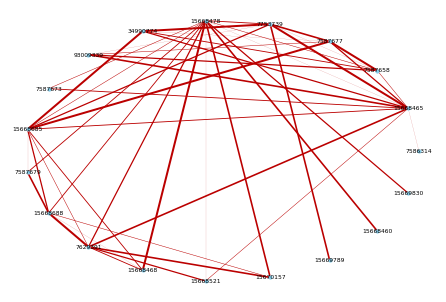

In [133]:
nx.draw_circular(G,
        node_size=10,
        node_color='#87CEEB',
        edge_color='#BB0000',
        width=np.linspace(0.1,2,len(np.unique(weights))),
        font_size=6,
        edge_cmap=plt.cm.Blues,
        with_labels=True)
#plt.show()
plt.savefig("graph.png", dpi=2000, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1) 

Returning the PageRank of the nodes in the graph.

https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html#networkx.algorithms.link_analysis.pagerank_alg.pagerank

*alpha* is the damping factor. *The PageRank theory holds that an imaginary surfer who is randomly clicking on links will eventually stop clicking. The probability, at any step, that the person will continue is a damping factor d. Various studies have tested different damping factors, but it is generally assumed that the damping factor will be set around 0.85.*

https://en.wikipedia.org/wiki/PageRank#Damping_factor

In [134]:
pr = nx.pagerank(G, alpha=0.85, weight='co')

In [135]:
keys = list(pr.keys())

Creating a dictionary with Description + SKU as key and PageRank as value, sorting it by value.

In [136]:
for key in keys:
    new_key = data.loc[data['SKU']==key]['Description'].iloc[0] + ' ' + str(key)  
    pr[new_key] = pr[key]
    del pr[key]

In [137]:
sorted_rank = {k: v for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)}

In [138]:
sorted_rank

{'Banana 15668478': 0.13338394040492282,
 'Root Vegetables 15668465': 0.11360517715502386,
 'Beans 15668685': 0.08537193537844968,
 'Health Drinks 7753739': 0.07876795000520415,
 'Glucose, Marie & Milk Biscuits 7629391': 0.07194746460986065,
 'Organic Salt,Sugar & Jaggery 7587658': 0.07118897419906908,
 'Root Vegetables 15668688': 0.06722342901243783,
 'Organic Dals & Pulses 7587677': 0.06255296637808933,
 'Eggs 34990774': 0.052635756811359104,
 'Beans 15668468': 0.04732121478363431,
 'Organic Flours 93009339': 0.037651903746017,
 'Bread 15668521': 0.03467360083985753,
 'Organic F&V 15670157': 0.03191680706154668,
 'Organic Flours 7587679': 0.02903655211771391,
 'Organic Dals & Pulses 7587673': 0.022714925904670953,
 'Other Rice Products 15669830': 0.016190363899053907,
 'Gourd & Cucumber 15668460': 0.014807759389562468,
 'Boiled Rice 15669789': 0.01458997945580422,
 'Snacky Nuts 7586314': 0.014419298847722308}

### Smart Basket Problem - Modeling

The code above was a sample of the PageRank approach. Now we apply this way of ranking products to the Smart Basket Problem.

1) Function which, given a dataset with chronologically sorted orders, splits the orders in training and test sets. Implementation details are in the function docstring.

In [139]:
def split_orders(data, n_splits, based_on):
    
    """
    With data for one or more customers (members) and considering that the orders are chronologically sorted,
    this function selects a 'n_splits' number of random percentages. Each percentage splits the data in training
    and test sets. The random percentage must be chosen between 60% and 80% of the dataset.
    
    The appropriate way of using this function is to split the data for one customer at a time, but it's prepared
    to work with any number of customers.
    
    Uses Monte Carlo approach (random selection without replacement).
    
    Returns two lists with len = n_splits containing the train and test splits respectively.
    """
               
    if based_on == 'SKU':
        member_orders = data.groupby(['Order','SKU']).size().unstack(fill_value=0)
    else:
        member_orders = data.groupby(['Order','Description']).size().unstack(fill_value=0)
    
    mo_train_list = []
    mo_test_list = []
    
    for i in range(n_splits):
        a, b = np.split(member_orders, [int((0.6 + 0.2*np.random.random())*len(member_orders))])
        mo_train_list.append(a)
        mo_test_list.append(b)
    
    return mo_train_list, mo_test_list

2) Define a model which applies PageRank with items co-occurrences as weights and returns a sorted rank for any training dataset.

In [140]:
def model_pagerank(mo_train):
    
    """
    Returns the sorted rank for a training set of orders. It takes the orders un-weighted.
    """
    
    # Matrix of co-occurrences
    co_occurrences = mo_train.T.dot(mo_train)
    co_occurrences.values[np.tril(np.ones(co_occurrences.shape)).astype(np.bool)] = 0
    
    # Stacking the matrix, to be used for ranking
    a = co_occurrences.stack()
    
    # Filtering the doubles of products which co-occur at least once
    a = a[a >= 1].rename_axis(('source', 'target')).reset_index(name='co')
    
    # Generating the network graph
    G = nx.from_pandas_edgelist(a, edge_attr='co')
    
    # Calculating the rank, using PageRank with co-occurrences as weights
    pr = nx.pagerank(G, alpha=0.85, weight='co')
    
    # Sorting the rank
    sorted_rank = {k: v for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)}
    
    return sorted_rank

3) For comparison, we define a model which applies PageRank which weights the items quantities with their recency. In this sense, when the co-occurrences matrix is created, it will have sum higher values for co-occurrences observed in more recent orders. Later, the PageRank will use these 'weighted' co-occurrences as weights.

In [141]:
# setting up the weights for recency
weights = {0:1.0,
           1:0.9,
           2:0.5, 
           3:0.2,
           4:0.1
}

In [142]:
"""
Using the for loop, we create a list of all orders and their assigned weight based on recency.

It is important to note that this recency is based on customer level:
a temporary dataset is created for each customer 'i', where their orders are sorted by column "Created On".

Based on this, a quintile is assigned based on recency ranging (0-4) with 0 being most recent and 4 most distant.

Based on the quintiles, the weights from the above are assigned to each order number.

These are appended as a list of datafrems to the initially empty list of orders.
"""

orders = []

for i in data['Member'].unique():
    temp = data[data['Member']==i]
    temp.sort_values(by=['Created On'], inplace=True)
    temp['quantile'] = pd.qcut(temp['Created On'], 5, labels=False)
    temp['weight'] = temp['quantile'].apply(lambda x: weights[x])
    orders.append(temp[['Order','weight']].groupby('Order').mean())

In [143]:
# Orders list of dataframes is concatenated to have all orders listed
orders = pd.concat(orders)

# Printing a sample
print('Total number of orders: ' + str(orders.count()[0]))
orders.head()

Total number of orders: 8386


,weight
Order,
6439309,0.1
6462335,0.1
6496410,0.1
6529279,0.1
6538989,0.1


In [144]:
def model_pagerank2(mo_train):
    
    """Returns the sorted rank for a training set of orders.
    
       Gives a higher weight to co-occurrences in most recent orders.
    """

    order_num = orders[orders.index.isin(mo_train.index)]
    order_num.sort_values(by='Order',inplace=True)
    mo_train = pd.DataFrame(mo_train.values*order_num.values, columns=mo_train.columns, index=mo_train.index)
    
    co_occurrences = mo_train.T.dot(mo_train)
    co_occurrences.values[np.tril(np.ones(co_occurrences.shape)).astype(np.bool)] = 0
    a = co_occurrences.stack()
    a = a[a >= 1].rename_axis(('source', 'target')).reset_index(name='co')
    G = nx.from_pandas_edgelist(a, edge_attr='co')
    pr = nx.pagerank(G, alpha=0.85, weight='co')
    sorted_rank = {k: v for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)}
    return sorted_rank

4) Using the result of the previous 'model' functions, the function below returns the top 't' products, with 't' being a chosen number of products to be recommended.

In [145]:
def topT(dictionary, t):
    
    """Returns the top t (recommended) products from a sorted rank of products"""
    
    return list(dictionary.keys())[:t]

### Smart Basket Problem - Testing Strategy

(The testing strategy below is inspired in the **Recommender Systems** book, section 7.5.4)

1. Considering all the sorted orders from a single customer, split the orders into training and testing sets with, for instance, 75% and 25% of the purchased items using Monte Carlo;
2. With the training set, calculate the PageRank and recommend 't' items;
3. Considering the 't' recommended items, for each order in the test set we compute the **precision** (percentage of recommended items that were consumed by the user), and the **recall** (percentage of consumed products that have been included in the recommendation list of size t).
4. Compute the mean precision and recall. Use them to compute the **F1-score** for the test sample.
5. Cross-validate the model (calculate the mean and std deviation of the F1-score).
6. Repeat the steps for the different ‘t’ values.
7. Repeat the steps for different models.

**What we get in the end is the F1-score for a model with all 't' possible numbers of recommendations, cross-validated among a 'm_members' number of customers and 'n_splits' number of training/testing splits.**

5) Define a function to calculate precision and recall for a test set of orders.

In [146]:
def precision_recall(mo_test, topT, t):
    
    """
    Returns the precision and the recall for a test set of orders.
    
    The precision is calculated for each order, counting the non-zero values in the 'topT' columns
    and dividing it by the number of recommendations.
    
    The recall is also calculated for each order. First, the function creates a list with the items in the order,
    then compares this list with the items included in the 'topT'. Divides the number of coincident products by the
    number of products consumed in this order.
    """

    mo_test['precision'] = np.count_nonzero(mo_test[topT], axis=1)/t
    mo_test['recall'] = mo_test.ne(0).apply(lambda x: mo_test.columns[x].tolist(), axis=1)    
    mo_test['recall'] = mo_test['recall'].apply(lambda x: np.divide(sum(1 for p in x if p in topT),
                                                                    len(x),
                                                                    where = (len(x)!=0) ))
                                                
    pre = np.mean(mo_test['precision'])
    rec = np.mean(mo_test['recall'])
       
    return pre, rec

6) Define the function to test the model, according to the strategy above.

In [147]:
def cross_validate_model(data, model, m_members = 5, n_splits =5, based_on = 'SKU', member_id = None):
     
    """
    Randomly select a number of different customers equal to 'm_members' and cross-validate the model
    with these customers using all possible number of recommendations. The maximum number of recommendations
    correspond to the size of the smallest set of products (SKU) ever bought by a customer in the selected sample.
       
    This function also performs cross-validation among different train/test splits.
       
    The resulting precision, recall and F1-score for the evaluated model are the average of the measures
    obtained for each train/test split and later for each customer in the sample.
       
    Returns precision_curve and recall_curve for the model, which corresponds to the precision and recall obtained
    for each number of recommendations (t).
       
    Precision_curve and recall_curve will later be used to plot the model results in comparison with other models.
       
    A model corresponds to a single PageRank implementation (which can use different ways of weighting the links).
    
    """
    
    print("Cross-validating the model with", m_members, "member(s) and", n_splits, "different train/test splits.")
    
    if member_id == None:
        members_sample = rd.sample(data['Member'].unique().tolist(), m_members)
    else:
        members_sample = [member_id]
    
    max_num_recommendations = 15
    
    precision_curve = []
    recall_curve = []
            
    for member in members_sample:
        
        df = data.loc[data['Member'] == member]
    
        if based_on == 'SKU':
            max_num_recommendations = min(len(df['SKU'].unique()), max_num_recommendations)
        else:
            max_num_recommendations = min(len(df['Description'].unique()), max_num_recommendations)
    
    members_metrics = {}
    
    for t in range(1, max_num_recommendations+1):
        
        member_precision_mean = []
        member_recall_mean = []
        member_f1_mean = []
        member_f1_stddev = []
        
        for member in members_sample:
        
            df = data.loc[data['Member'] == member]
    
            mo_train_list, mo_test_list = split_orders(df, n_splits, based_on)
    
            member_precision_list = []
            member_recall_list = []
            member_f1_list = []
        
            for train_orders, test_orders in zip(mo_train_list, mo_test_list):

                rank = model(train_orders)
                top = topT(rank, t)
                pre, rec = precision_recall(test_orders, top, t)
                member_precision_list.append(pre)
                member_recall_list.append(rec)
                if (pre == 0 and rec == 0):
                    member_f1_list.append(0)
                else:
                    member_f1_list.append(2 * (pre * rec) / (pre + rec))

            members_metrics[member, t] = [round(np.mean(member_precision_list),3),
                                          round(np.mean(member_recall_list),3),
                                          round(np.mean(member_f1_list),3),
                                          round(np.std(member_f1_list),3)]
            
            member_precision_mean.append(members_metrics[member, t][0])
            member_recall_mean.append(members_metrics[member, t][1])
            member_f1_mean.append(members_metrics[member, t][2])
            member_f1_stddev.append(members_metrics[member, t][3])        
        
        precision_curve.append(round(np.mean(member_precision_mean),3))
        recall_curve.append(round(np.mean(member_recall_mean),3))
        
        f1_mean_for_t = round(np.mean(member_f1_mean),3)
        f1_stddev_for_t = round(np.mean(member_f1_stddev),3)

        print("Model with", t, "recommendations: F1-score mean (", f1_mean_for_t,
              ") and F1-score std dev (", f1_stddev_for_t,").")
        
    return precision_curve, recall_curve, members_metrics

7) For comparison, define another testing function with almost the same behavior as above, but with a difference that the maximum number of recommendations to be tested with each customer is the average size of the baskets for this customer. This function can be used to optimize the results when applying (in production) to one customer at a time.

In [148]:
def cross_validate_model_avg(data, model, m_members = 5, n_splits = 5, based_on = 'SKU', member_id = None):
     
    """
    (Almost) the same function as above, with a difference that, in the case that the evaluation unit is the SKU,
    the maximum number of recommended products for each tested customer is now set to be the average of all client basket's sizes
    plus five.
    """
    
    print("Cross-validating the model with", m_members, "member(s) and", n_splits, "different train/test splits.")
    
    if member_id == None:
        members_sample = rd.sample(data['Member'].unique().tolist(), m_members)
    else:
        members_sample = [member_id]
    
    max_num_recommendations = 15
    n_recommendations_list = []
    
    precision_curve = []
    recall_curve = []
            
    for member in members_sample:
        
        df = data.loc[data['Member'] == member]
    
        if based_on == 'SKU':
            n_recommendations_list.append(df.groupby(by=['Order']).size().mean())
        else:
            max_num_recommendations = min(len(df['Description'].unique()), max_num_recommendations)
    
    if based_on == 'SKU':
        
        max_num_recommendations = int(np.mean(n_recommendations_list))+5                              
    
    members_metrics = {}
                                          
    for t in range(np.max(max_num_recommendations - 5, 0), max_num_recommendations):
        
        member_precision_mean = []
        member_recall_mean = []
        member_f1_mean = []
        member_f1_stddev = []
        
        for member in members_sample:
        
            df = data.loc[data['Member'] == member]
    
            mo_train_list, mo_test_list = split_orders(df, n_splits, based_on)
    
            member_precision_list = []
            member_recall_list = []
            member_f1_list = []
        
            for train_orders, test_orders in zip(mo_train_list, mo_test_list):

                rank = model(train_orders)
                top = topT(rank, t)
                pre, rec = precision_recall(test_orders, top, t)
                member_precision_list.append(pre)
                member_recall_list.append(rec)
                if (pre == 0 and rec == 0):
                    member_f1_list.append(0)
                else:
                    member_f1_list.append(2 * (pre * rec) / (pre + rec))

            members_metrics[member, t] = [round(np.mean(member_precision_list),3),
                                          round(np.mean(member_recall_list),3),
                                          round(np.mean(member_f1_list),3),
                                          round(np.std(member_f1_list),3)]
            
            member_precision_mean.append(members_metrics[member, t][0])
            member_recall_mean.append(members_metrics[member, t][1])
            member_f1_mean.append(members_metrics[member, t][2])
            member_f1_stddev.append(members_metrics[member, t][3])
        
        precision_curve.append(round(np.mean(member_precision_mean),3))
        recall_curve.append(round(np.mean(member_recall_mean),3))
        
        f1_mean_for_t = round(np.mean(member_f1_mean),3)
        f1_stddev_for_t = round(np.mean(member_f1_stddev),3)

        print("Model with", t, "recommendations: F1-score mean (", f1_mean_for_t,
              ") and F1-score std dev (", f1_stddev_for_t,").")
        
    return precision_curve, recall_curve, members_metric

## Testing recommender on 5 random clients and:

### Showing the overall result of the model

In [200]:
pr_curve, re_curve, members_metric = cross_validate_model(data, model_pagerank, m_members = 106)

Cross-validating the model with 106 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.09 ) and F1-score std dev ( 0.01 ).
Model with 2 recommendations: F1-score mean ( 0.138 ) and F1-score std dev ( 0.014 ).
Model with 3 recommendations: F1-score mean ( 0.174 ) and F1-score std dev ( 0.012 ).
Model with 4 recommendations: F1-score mean ( 0.194 ) and F1-score std dev ( 0.013 ).
Model with 5 recommendations: F1-score mean ( 0.212 ) and F1-score std dev ( 0.013 ).
Model with 6 recommendations: F1-score mean ( 0.222 ) and F1-score std dev ( 0.015 ).
Model with 7 recommendations: F1-score mean ( 0.232 ) and F1-score std dev ( 0.013 ).
Model with 8 recommendations: F1-score mean ( 0.238 ) and F1-score std dev ( 0.013 ).
Model with 9 recommendations: F1-score mean ( 0.244 ) and F1-score std dev ( 0.013 ).
Model with 10 recommendations: F1-score mean ( 0.246 ) and F1-score std dev ( 0.013 ).
Model with 11 recommendations: F1-score mean ( 0.25 ) and F1

### Showing the clients results individually

Note that the optimal number of recommendations vary.

In [150]:
sorted_members_metric = {k: v for k, v in sorted(members_metric.items(), key=lambda item: item[0], reverse=False)}

In [151]:
sorted_members_metric

{('M14746', 1): [0.267, 0.026, 0.048, 0.006],
 ('M14746', 2): [0.212, 0.039, 0.066, 0.01],
 ('M14746', 3): [0.224, 0.064, 0.1, 0.006],
 ('M14746', 4): [0.233, 0.087, 0.126, 0.019],
 ('M14746', 5): [0.271, 0.127, 0.173, 0.007],
 ('M14746', 6): [0.282, 0.155, 0.2, 0.002],
 ('M14746', 7): [0.233, 0.151, 0.183, 0.01],
 ('M14746', 8): [0.219, 0.168, 0.19, 0.022],
 ('M14746', 9): [0.247, 0.221, 0.233, 0.013],
 ('M14746', 10): [0.234, 0.23, 0.232, 0.004],
 ('M14746', 11): [0.246, 0.267, 0.256, 0.015],
 ('M14746', 12): [0.239, 0.281, 0.258, 0.008],
 ('M14746', 13): [0.231, 0.294, 0.259, 0.011],
 ('M14746', 14): [0.216, 0.298, 0.251, 0.008],
 ('M14746', 15): [0.213, 0.313, 0.253, 0.002],
 ('M42182', 1): [0.42, 0.092, 0.15, 0.008],
 ('M42182', 2): [0.277, 0.116, 0.164, 0.004],
 ('M42182', 3): [0.198, 0.124, 0.152, 0.004],
 ('M42182', 4): [0.191, 0.157, 0.172, 0.01],
 ('M42182', 5): [0.191, 0.196, 0.194, 0.016],
 ('M42182', 6): [0.187, 0.225, 0.204, 0.02],
 ('M42182', 7): [0.197, 0.266, 0.226, 0.

### Testing recommender on 3 sub-groups of clients:

- low = low variability in products, low number of unique SKU customer buys
- mid = medium variability, medium number of unique SKU customer buys
- high = high cariability, wide range of products customers buy

While on average with randomly selected clients recommender achieves around 20-25% F1 score, we illustrate that applied to clients with distinct purchasing patterns we can achive as much as 40% F1, with customers that make more repeated buys than the others who try a more wide range of products.

In [201]:
#based on 10 random clients non-weighted model (without grouping them)
pr_curve, re_curve, members_metric = cross_validate_model(data, model_pagerank, m_members = 20)

Cross-validating the model with 20 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.098 ) and F1-score std dev ( 0.013 ).
Model with 2 recommendations: F1-score mean ( 0.143 ) and F1-score std dev ( 0.011 ).
Model with 3 recommendations: F1-score mean ( 0.18 ) and F1-score std dev ( 0.017 ).
Model with 4 recommendations: F1-score mean ( 0.204 ) and F1-score std dev ( 0.015 ).
Model with 5 recommendations: F1-score mean ( 0.219 ) and F1-score std dev ( 0.015 ).
Model with 6 recommendations: F1-score mean ( 0.23 ) and F1-score std dev ( 0.01 ).
Model with 7 recommendations: F1-score mean ( 0.24 ) and F1-score std dev ( 0.011 ).
Model with 8 recommendations: F1-score mean ( 0.242 ) and F1-score std dev ( 0.014 ).
Model with 9 recommendations: F1-score mean ( 0.243 ) and F1-score std dev ( 0.012 ).
Model with 10 recommendations: F1-score mean ( 0.25 ) and F1-score std dev ( 0.011 ).
Model with 11 recommendations: F1-score mean ( 0.254 ) and F1-sc

In [202]:
#based on 10 random clients weighted model (without grouing them)
pr_curve2, re_curve2, members_metric2 = cross_validate_model(data, model_pagerank2, m_members = 20)

Cross-validating the model with 20 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.074 ) and F1-score std dev ( 0.011 ).
Model with 2 recommendations: F1-score mean ( 0.118 ) and F1-score std dev ( 0.016 ).
Model with 3 recommendations: F1-score mean ( 0.142 ) and F1-score std dev ( 0.017 ).
Model with 4 recommendations: F1-score mean ( 0.164 ) and F1-score std dev ( 0.014 ).
Model with 5 recommendations: F1-score mean ( 0.176 ) and F1-score std dev ( 0.017 ).
Model with 6 recommendations: F1-score mean ( 0.18 ) and F1-score std dev ( 0.015 ).
Model with 7 recommendations: F1-score mean ( 0.188 ) and F1-score std dev ( 0.016 ).
Model with 8 recommendations: F1-score mean ( 0.198 ) and F1-score std dev ( 0.016 ).
Model with 9 recommendations: F1-score mean ( 0.202 ) and F1-score std dev ( 0.015 ).
Model with 10 recommendations: F1-score mean ( 0.202 ) and F1-score std dev ( 0.019 ).
Model with 11 recommendations: F1-score mean ( 0.212 ) and F

In [203]:
#grouping into 3 test groups

c=pd.DataFrame(data.groupby('Member')['SKU'].nunique())
data_low=data[data['Member'].isin(c[c.SKU<100].index)]
data_mid=data[data['Member'].isin(c[c.SKU.between(100, 150)].index)]
data_high=data[data['Member'].isin(c[c.SKU>150].index)]

In [207]:
#testing on samples from group 1 = low unique SKU

pr_curve_low1, re_curve_low1, members_metric_low1 = cross_validate_model(data_low, model_pagerank)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.139 ) and F1-score std dev ( 0.005 ).
Model with 2 recommendations: F1-score mean ( 0.226 ) and F1-score std dev ( 0.015 ).
Model with 3 recommendations: F1-score mean ( 0.292 ) and F1-score std dev ( 0.021 ).
Model with 4 recommendations: F1-score mean ( 0.337 ) and F1-score std dev ( 0.015 ).
Model with 5 recommendations: F1-score mean ( 0.358 ) and F1-score std dev ( 0.018 ).
Model with 6 recommendations: F1-score mean ( 0.376 ) and F1-score std dev ( 0.014 ).
Model with 7 recommendations: F1-score mean ( 0.38 ) and F1-score std dev ( 0.016 ).
Model with 8 recommendations: F1-score mean ( 0.388 ) and F1-score std dev ( 0.016 ).
Model with 9 recommendations: F1-score mean ( 0.392 ) and F1-score std dev ( 0.013 ).
Model with 10 recommendations: F1-score mean ( 0.392 ) and F1-score std dev ( 0.016 ).
Model with 11 recommendations: F1-score mean ( 0.395 ) and F1

In [208]:
#testing on samples from group 1 = low unique SKU
pr_curve_low2, re_curve_low2, members_metric_low2 = cross_validate_model(data_low, model_pagerank2)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.065 ) and F1-score std dev ( 0.011 ).
Model with 2 recommendations: F1-score mean ( 0.141 ) and F1-score std dev ( 0.022 ).
Model with 3 recommendations: F1-score mean ( 0.198 ) and F1-score std dev ( 0.019 ).
Model with 4 recommendations: F1-score mean ( 0.216 ) and F1-score std dev ( 0.02 ).
Model with 5 recommendations: F1-score mean ( 0.222 ) and F1-score std dev ( 0.016 ).
Model with 6 recommendations: F1-score mean ( 0.255 ) and F1-score std dev ( 0.016 ).
Model with 7 recommendations: F1-score mean ( 0.27 ) and F1-score std dev ( 0.021 ).
Model with 8 recommendations: F1-score mean ( 0.272 ) and F1-score std dev ( 0.018 ).
Model with 9 recommendations: F1-score mean ( 0.295 ) and F1-score std dev ( 0.017 ).
Model with 10 recommendations: F1-score mean ( 0.283 ) and F1-score std dev ( 0.022 ).
Model with 11 recommendations: F1-score mean ( 0.278 ) and F1-

In [209]:
#testing on samples from group 1 = med unique SKU
pr_curve_mid1, re_curve_mid1, members_metric_mid1 = cross_validate_model(data_mid, model_pagerank)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.118 ) and F1-score std dev ( 0.023 ).
Model with 2 recommendations: F1-score mean ( 0.178 ) and F1-score std dev ( 0.017 ).
Model with 3 recommendations: F1-score mean ( 0.247 ) and F1-score std dev ( 0.011 ).
Model with 4 recommendations: F1-score mean ( 0.269 ) and F1-score std dev ( 0.012 ).
Model with 5 recommendations: F1-score mean ( 0.281 ) and F1-score std dev ( 0.007 ).
Model with 6 recommendations: F1-score mean ( 0.283 ) and F1-score std dev ( 0.015 ).
Model with 7 recommendations: F1-score mean ( 0.29 ) and F1-score std dev ( 0.01 ).
Model with 8 recommendations: F1-score mean ( 0.302 ) and F1-score std dev ( 0.014 ).
Model with 9 recommendations: F1-score mean ( 0.3 ) and F1-score std dev ( 0.013 ).
Model with 10 recommendations: F1-score mean ( 0.304 ) and F1-score std dev ( 0.013 ).
Model with 11 recommendations: F1-score mean ( 0.304 ) and F1-sc

In [210]:
#testing on samples from group 1 = med unique SKU
pr_curve_mid2, re_curve_mid2, members_metric_mid2 = cross_validate_model(data_mid, model_pagerank2)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.084 ) and F1-score std dev ( 0.004 ).
Model with 2 recommendations: F1-score mean ( 0.111 ) and F1-score std dev ( 0.005 ).
Model with 3 recommendations: F1-score mean ( 0.129 ) and F1-score std dev ( 0.012 ).
Model with 4 recommendations: F1-score mean ( 0.156 ) and F1-score std dev ( 0.017 ).
Model with 5 recommendations: F1-score mean ( 0.176 ) and F1-score std dev ( 0.023 ).
Model with 6 recommendations: F1-score mean ( 0.177 ) and F1-score std dev ( 0.01 ).
Model with 7 recommendations: F1-score mean ( 0.192 ) and F1-score std dev ( 0.015 ).
Model with 8 recommendations: F1-score mean ( 0.187 ) and F1-score std dev ( 0.011 ).
Model with 9 recommendations: F1-score mean ( 0.197 ) and F1-score std dev ( 0.012 ).
Model with 10 recommendations: F1-score mean ( 0.194 ) and F1-score std dev ( 0.014 ).
Model with 11 recommendations: F1-score mean ( 0.199 ) and F1

In [211]:
#testing on samples from group 1 = high unique SKU
pr_curve_high1, re_curve_high1, members_metric_high1 = cross_validate_model(data_high, model_pagerank)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.072 ) and F1-score std dev ( 0.006 ).
Model with 2 recommendations: F1-score mean ( 0.111 ) and F1-score std dev ( 0.013 ).
Model with 3 recommendations: F1-score mean ( 0.138 ) and F1-score std dev ( 0.012 ).
Model with 4 recommendations: F1-score mean ( 0.163 ) and F1-score std dev ( 0.017 ).
Model with 5 recommendations: F1-score mean ( 0.174 ) and F1-score std dev ( 0.014 ).
Model with 6 recommendations: F1-score mean ( 0.203 ) and F1-score std dev ( 0.01 ).
Model with 7 recommendations: F1-score mean ( 0.207 ) and F1-score std dev ( 0.013 ).
Model with 8 recommendations: F1-score mean ( 0.214 ) and F1-score std dev ( 0.015 ).
Model with 9 recommendations: F1-score mean ( 0.219 ) and F1-score std dev ( 0.014 ).
Model with 10 recommendations: F1-score mean ( 0.22 ) and F1-score std dev ( 0.016 ).
Model with 11 recommendations: F1-score mean ( 0.232 ) and F1-

In [212]:
#testing on samples from group 1 = high unique SKU
pr_curve_high2, re_curve_high2, members_metric_high2 = cross_validate_model(data_high, model_pagerank2)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.056 ) and F1-score std dev ( 0.014 ).
Model with 2 recommendations: F1-score mean ( 0.117 ) and F1-score std dev ( 0.016 ).
Model with 3 recommendations: F1-score mean ( 0.14 ) and F1-score std dev ( 0.018 ).
Model with 4 recommendations: F1-score mean ( 0.185 ) and F1-score std dev ( 0.008 ).
Model with 5 recommendations: F1-score mean ( 0.201 ) and F1-score std dev ( 0.012 ).
Model with 6 recommendations: F1-score mean ( 0.209 ) and F1-score std dev ( 0.013 ).
Model with 7 recommendations: F1-score mean ( 0.218 ) and F1-score std dev ( 0.013 ).
Model with 8 recommendations: F1-score mean ( 0.219 ) and F1-score std dev ( 0.015 ).
Model with 9 recommendations: F1-score mean ( 0.22 ) and F1-score std dev ( 0.016 ).
Model with 10 recommendations: F1-score mean ( 0.219 ) and F1-score std dev ( 0.01 ).
Model with 11 recommendations: F1-score mean ( 0.22 ) and F1-sc

In [213]:
precision_curves_pagerank = [pr_curve_low1, pr_curve_mid1, pr_curve_high1, pr_curve]
recall_curves_pagerank = [re_curve_low1, re_curve_mid1, re_curve_high1, re_curve]
models_pagerank = ['pagerank-SKU-low', 'pagerank-SKU-mid', 'pagerank-SKU-high', 'pagerank-SKU-full']

In [214]:
precision_curves_pagerank2 = [pr_curve_low2, pr_curve_mid2, pr_curve_high2, pr_curve2]
recall_curves_pagerank2 = [re_curve_low2, re_curve_mid2, re_curve_high2, re_curve2]
models_pagerank2 = ['pagerank2-SKU-low', 'pagerank2-SKU-mid', 'pagerank2-SKU-high', 'pagerank2-SKU-full']

Define a function to compare the models and group selections, plotting the precision an recall curves with the baseline F1 curves.

In [215]:
def plot_precision_recall(precision_curves, recall_curves, models):
    
    """Plot the precision-recall curve for different t recommendations"""
    
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'darkgreen','purple'])

    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.1, 0.7, num=7)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.1)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.65, y[45] + 0.02))

    lines.append(l)
    labels.append('f1 curves')
    
    for pr_curve, re_curve, color, model in zip(precision_curves, recall_curves, colors, models):
        l, = plt.plot(re_curve, pr_curve, color=color, lw=1)
        lines.append(l)
        labels.append('Precision-recall for model {0}'
                      ''.format(model))
        for i in range(len(pr_curve)):
            plt.annotate(i+1, (re_curve[i], pr_curve[i]),
                         fontsize=9)

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 0.80])
    plt.ylim([0.0, 0.80])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for t recommendations')
    plt.legend(lines, labels, loc='upper right', prop=dict(size=10))

    plt.show()

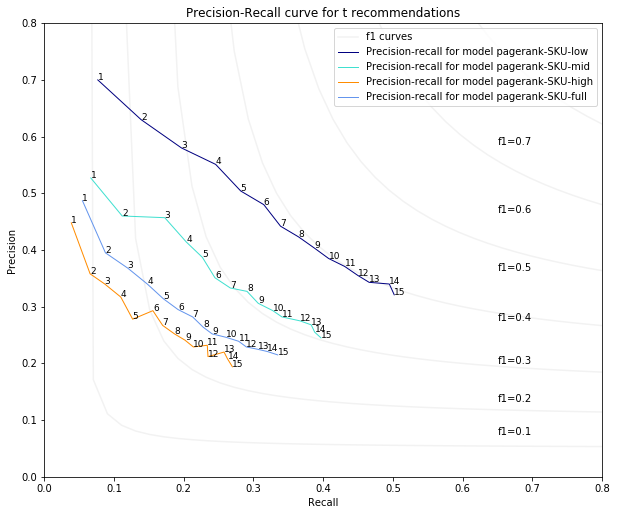

In [216]:
plot_precision_recall(precision_curves_pagerank, recall_curves_pagerank, models_pagerank)

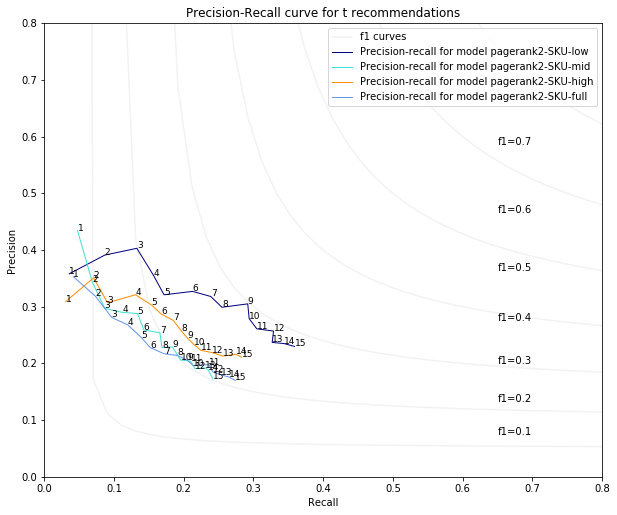

In [217]:
plot_precision_recall(precision_curves_pagerank2, recall_curves_pagerank2, models_pagerank2)

### Smart basket set to average basket (based on past) and tested on target groups

Now we use the testing approach in which the maximum number of recommended products for each tested customer is now set to be the average of all client basket's sizes plus five.

In [164]:
#avg, avg+1, avg+2, avg+3, avg+4 recommendation with random sampling of all clients
pr_curve, re_curve, members_metric = cross_validate_model_avg(data, model_pagerank)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 9 recommendations: F1-score mean ( 0.265 ) and F1-score std dev ( 0.016 ).
Model with 10 recommendations: F1-score mean ( 0.268 ) and F1-score std dev ( 0.015 ).
Model with 11 recommendations: F1-score mean ( 0.268 ) and F1-score std dev ( 0.016 ).
Model with 12 recommendations: F1-score mean ( 0.272 ) and F1-score std dev ( 0.025 ).
Model with 13 recommendations: F1-score mean ( 0.262 ) and F1-score std dev ( 0.025 ).


In [165]:
#avg, avg+1, avg+2, avg+3, avg+4 recommendation with random sampling of all clients
pr_curve, re_curve, members_metric = cross_validate_model_avg(data, model_pagerank2)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 7 recommendations: F1-score mean ( 0.198 ) and F1-score std dev ( 0.013 ).
Model with 8 recommendations: F1-score mean ( 0.205 ) and F1-score std dev ( 0.016 ).
Model with 9 recommendations: F1-score mean ( 0.218 ) and F1-score std dev ( 0.011 ).
Model with 10 recommendations: F1-score mean ( 0.222 ) and F1-score std dev ( 0.011 ).
Model with 11 recommendations: F1-score mean ( 0.223 ) and F1-score std dev ( 0.008 ).


In [166]:
pr_curve, re_curve, members_metric = cross_validate_model_avg(data_low, model_pagerank)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 6 recommendations: F1-score mean ( 0.399 ) and F1-score std dev ( 0.026 ).
Model with 7 recommendations: F1-score mean ( 0.396 ) and F1-score std dev ( 0.028 ).
Model with 8 recommendations: F1-score mean ( 0.39 ) and F1-score std dev ( 0.029 ).
Model with 9 recommendations: F1-score mean ( 0.388 ) and F1-score std dev ( 0.022 ).
Model with 10 recommendations: F1-score mean ( 0.397 ) and F1-score std dev ( 0.014 ).


In [167]:
pr_curve, re_curve, members_metric = cross_validate_model_avg(data_low, model_pagerank2)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 7 recommendations: F1-score mean ( 0.318 ) and F1-score std dev ( 0.026 ).
Model with 8 recommendations: F1-score mean ( 0.318 ) and F1-score std dev ( 0.021 ).
Model with 9 recommendations: F1-score mean ( 0.329 ) and F1-score std dev ( 0.02 ).
Model with 10 recommendations: F1-score mean ( 0.338 ) and F1-score std dev ( 0.011 ).
Model with 11 recommendations: F1-score mean ( 0.318 ) and F1-score std dev ( 0.02 ).


In [168]:
pr_curve, re_curve, members_metric = cross_validate_model_avg(data_mid, model_pagerank)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 8 recommendations: F1-score mean ( 0.246 ) and F1-score std dev ( 0.011 ).
Model with 9 recommendations: F1-score mean ( 0.252 ) and F1-score std dev ( 0.013 ).
Model with 10 recommendations: F1-score mean ( 0.255 ) and F1-score std dev ( 0.01 ).
Model with 11 recommendations: F1-score mean ( 0.257 ) and F1-score std dev ( 0.01 ).
Model with 12 recommendations: F1-score mean ( 0.254 ) and F1-score std dev ( 0.012 ).


In [169]:
pr_curve, re_curve, members_metric = cross_validate_model_avg(data_mid, model_pagerank2)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 8 recommendations: F1-score mean ( 0.258 ) and F1-score std dev ( 0.018 ).
Model with 9 recommendations: F1-score mean ( 0.265 ) and F1-score std dev ( 0.007 ).
Model with 10 recommendations: F1-score mean ( 0.261 ) and F1-score std dev ( 0.012 ).
Model with 11 recommendations: F1-score mean ( 0.258 ) and F1-score std dev ( 0.013 ).
Model with 12 recommendations: F1-score mean ( 0.267 ) and F1-score std dev ( 0.015 ).


In [170]:
pr_curve, re_curve, members_metric = cross_validate_model_avg(data_high, model_pagerank)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 8 recommendations: F1-score mean ( 0.227 ) and F1-score std dev ( 0.01 ).
Model with 9 recommendations: F1-score mean ( 0.23 ) and F1-score std dev ( 0.012 ).
Model with 10 recommendations: F1-score mean ( 0.232 ) and F1-score std dev ( 0.013 ).
Model with 11 recommendations: F1-score mean ( 0.233 ) and F1-score std dev ( 0.013 ).
Model with 12 recommendations: F1-score mean ( 0.236 ) and F1-score std dev ( 0.011 ).


In [171]:
pr_curve, re_curve, members_metric = cross_validate_model_avg(data_high, model_pagerank2)

Cross-validating the model with 5 member(s) and 5 different train/test splits.
Model with 11 recommendations: F1-score mean ( 0.137 ) and F1-score std dev ( 0.012 ).
Model with 12 recommendations: F1-score mean ( 0.141 ) and F1-score std dev ( 0.011 ).
Model with 13 recommendations: F1-score mean ( 0.131 ) and F1-score std dev ( 0.022 ).
Model with 14 recommendations: F1-score mean ( 0.135 ) and F1-score std dev ( 0.019 ).
Model with 15 recommendations: F1-score mean ( 0.136 ) and F1-score std dev ( 0.023 ).


### Validating results with spot-check 

- Simulating recommender for a single client 

In [172]:
# Member: M99030
# an example of sub-group low
m99030_pr, m99030_re, m99030_metrics = cross_validate_model(data, model_pagerank, m_members = 1, member_id = 'M99030')

Cross-validating the model with 1 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.216 ) and F1-score std dev ( 0.008 ).
Model with 2 recommendations: F1-score mean ( 0.352 ) and F1-score std dev ( 0.021 ).
Model with 3 recommendations: F1-score mean ( 0.469 ) and F1-score std dev ( 0.027 ).
Model with 4 recommendations: F1-score mean ( 0.494 ) and F1-score std dev ( 0.004 ).
Model with 5 recommendations: F1-score mean ( 0.556 ) and F1-score std dev ( 0.017 ).
Model with 6 recommendations: F1-score mean ( 0.533 ) and F1-score std dev ( 0.024 ).
Model with 7 recommendations: F1-score mean ( 0.527 ) and F1-score std dev ( 0.018 ).
Model with 8 recommendations: F1-score mean ( 0.512 ) and F1-score std dev ( 0.017 ).
Model with 9 recommendations: F1-score mean ( 0.521 ) and F1-score std dev ( 0.023 ).
Model with 10 recommendations: F1-score mean ( 0.501 ) and F1-score std dev ( 0.015 ).
Model with 11 recommendations: F1-score mean ( 0.5 ) and F1-

In [173]:
print('Member --- #Recommendations --- Precision --- Recall --- F1-score --- F1 Std Dev')
for (key1, key2), value in m99030_metrics.items():
    print(key1,'         ',
          key2,'             ',
          value[0],'       ',
          value[1],'     ',
          value[2],'     ',
          value[3])

Member --- #Recommendations --- Precision --- Recall --- F1-score --- F1 Std Dev
M99030           1               0.913         0.123       0.216       0.008
M99030           2               0.836         0.223       0.352       0.021
M99030           3               0.817         0.329       0.469       0.027
M99030           4               0.723         0.376       0.494       0.004
M99030           5               0.699         0.462       0.556       0.017
M99030           6               0.612         0.472       0.533       0.024
M99030           7               0.556         0.501       0.527       0.018
M99030           8               0.509         0.516       0.512       0.017
M99030           9               0.49         0.556       0.521       0.023
M99030           10               0.453         0.56       0.501       0.015
M99030           11               0.435         0.589       0.5       0.013
M99030           12               0.418         0.61       0.496       0.0

### The 'Did you forget?' Problem - Modeling

### Similarity measures

#### Let X = (1, 1, 0, 0, 1) and Y = (0, 1, 1, 0, 0), where **1** indicates that the customer purchased the item X during a specific order and **0** indicates otherwise:

**Cosine Similarity:**

<img src="https://drive.google.com/uc?export=download&id=1bgCtGkjQ7buPhsMPi_Xs27aVj2DiSv1U" alt="drawing" width="200" align="left"/><br/><br/><br/>

Close to 1: orders are very similar <br/>
Close to 0: orders are dissimilar <br/>
Close to -1: orders are completely opposite <br/>

**Jaccard Coefficient:**

<img src="https://drive.google.com/uc?export=download&id=1CXcdCtVfNkeMDUBmVdwnA29co05I4VDZ" alt="drawing" width="200" align="left"/><br/><br/><br/>

Where 𝑛(𝑋 ∩ 𝑌) is the number of units in 𝑋 ∩ 𝑌 and 𝑛(𝑋 ∪ 𝑌) is the number of units in 𝑋 ∪ 𝑌.

<br/>

**Dice Coefficient:** 

<img src="https://drive.google.com/uc?export=download&id=10y6zhz4N-1d5StmyKhdK2Dhp4CQKHaq_" alt="drawing" width="200" align="left"/><br/><br/><br/>

Where 𝑛(𝑋 ∩ 𝑌) is the number of units in 𝑋 ∩ 𝑌, 𝑛(𝑋) is the number of elements in 𝑋 and 𝑛(𝑌) is the number of elements in 𝑌.

1) Define a function for each of the similarity measures:

In [174]:
def model_dice(mo_train):
    """
    Receives a training set ('mo_train') from a list ('mo_train_list') created by 'split_orders' function.
    For the training set returns the dice coefficient for each pair of products (by 'SKU' or 'Description').
    """
    
    column_combinations = list(combinations(mo_train.columns,2))
    dice_dict = {}
    n_column = {}
    
    for column in mo_train.columns:
        n_column[column] = np.sum(mo_train[column].ne(0))
    
    for cc in column_combinations:
        n_xy = np.sum(np.logical_and(mo_train[cc[0]].ne(0), mo_train[cc[1]].ne(0)))
        n_x = n_column[cc[0]]
        n_y = n_column[cc[1]]
        
        if ((n_x + n_y) != 0):
            dice = 2*n_xy/(n_x + n_y)
        else:
            dice = 0
        
        dice_dict[cc] = dice
        
    return dice_dict

In [175]:
def model_jaccard(mo_train):
    """
    Receives a training set ('mo_train') from a list ('mo_train_list') created by 'split_orders' function.
    For the training set returns the jaccard coefficient for each pair of products (by 'SKU' or 'Description').
    """
    
    column_combinations = list(combinations(mo_train.columns,2))
    jacc_dict = {}
    
    for cc in column_combinations:
        n_xy = np.sum(np.logical_and(mo_train[cc[0]].ne(0), mo_train[cc[1]].ne(0)))
        n_xuy = np.sum(np.logical_or(mo_train[cc[0]].ne(0), mo_train[cc[1]].ne(0)))
        
        if (n_xuy != 0):
            jaccard = n_xy/n_xuy
        else:
            jaccard = 0
        
        jacc_dict[cc] = jaccard
        
    return jacc_dict

In [176]:
def model_cosine(mo_train):
    """
    Receives a training set ('mo_train') from a list ('mo_train_list') created by 'split_orders' function.
    For the training set returns the cosine similarity for each pair of products (by 'SKU' or 'Description').
    """
    
    column_combinations = list(combinations(mo_train.columns,2))
    cosine_dict = {}
    n_column = {}
    
    for cc in column_combinations:
        dot_xy = mo_train[cc[0]].dot(mo_train[cc[1]])
        sum_dot_xy = dot_xy.sum()
        
        x_2 = mo_train[cc[0]] ** 2
        y_2 = mo_train[cc[1]] ** 2
        
        root_x_2 = np.sqrt(x_2.sum())
        root_y_2 = np.sqrt(y_2.sum())
        
        if (root_x_2 != 0) and (root_y_2 != 0):
            cosine = sum_dot_xy / (root_x_2 * root_y_2)
        else:
            cosine = 0
        
        cosine_dict[cc] = cosine
        
    return cosine_dict

### "Did you forget?" Problem - Testing Strategy

1. Considering all the orders from a single customer, split the orders into training and testing sets with, for instance, 75% and 25% of the purchased items using Monte Carlo;
2. With the training set, calculate the similarity measure and generate a dictionary with pairwise similarity;
3. The model is tested with different numbers of recommendations from 1 to a maximum of 'max_num_recommendations' possibly forgotten items. Also, for each order in the test set we compute the **precision** (percentage of recommended items that were consumed by the user), and the **recall** (percentage of consumed products that have been included in the recommendation list of size t).
4. Compute the mean precision and recall. Use them to compute the **F1-score** for the test sample.
5. Cross-validate the model (calculate the mean and std deviation of the F1 score).
6. Repeat the steps for the different ‘n’ values.
7. Repeat the steps for different models.

For this problem, **precision** is the percentage of possibly forgotten (recommended) products that were consumed by the user (i.e., included in the hidden basket), and **recall** is the percentage of hidden products that have been included in the recommendation.

2) Define a function that 'hides' some items from a single order for testing purposes.

In [177]:
def hold_items(mo_test):
    
    """
    Randomly splits a test order (mo_test), holding some items to be used when testing the model.
    Returns a new version of mo_test, which includes three new columns:
        1) list containing items (subsets of SKUs or Descriptions) that are in the basket;
        2) list with 'visible' items;
        3) list with 'hidden' items.
    """
    
    def nonzero_items(order):
        return order.iloc[order.to_numpy().nonzero()].index.tolist()
    
    def random_hide(basket):
        rd.shuffle(basket)
        if len(basket) != 1:       
            point = rd.randint(1, len(basket)-1)
            return basket[:point], basket[point:]
        else:
            return basket, []
    
    mo_test['basket'] = mo_test.apply(nonzero_items, axis=1)
    
    temp = mo_test['basket'].apply(random_hide)
    temp = pd.DataFrame(temp)
    mo_test['visible'] = temp.apply(lambda x: [y[0] for y in x])
    mo_test['hidden'] = temp.apply(lambda x: [y[1] for y in x])
    
    return mo_test

3) Define a function for recommending N products based on the chosen similarity measure (model).

In [178]:
def forgotN(visible_basket, sim_dict, sim_minimum, N):
    
    """
    Receives a dict (sim_dict) containing products doubles and ther similarities.
    Returns the top N recommended products according to the following criteria:
    1) The recommended products must not be in the current basket (visible_basket);
    2) The recommended procucts must have a minimum similarity with any another product (already in the basket);
    3) The number of recommended products must be N or less (depending on the minimum similarity).
    """
    
    # Remove all similarities equal to zero (for performance purposes)
    sim_dict = {key:val for key, val in sim_dict.items() if val != 0}

    basket_sim_dict = {}
    
    # Maintaining the sim_dict entries which include items in the current basket
    # iterating over items in the current basket, maintaining only their similarities with any product in basket_sim_dict
    for i in visible_basket:
        i_dict = {key:val for key, val in sim_dict.items() if i in key}
        basket_sim_dict = {**basket_sim_dict, **i_dict}
    
    # Removing the entries with similarities below 'sim_minimum'
    basket_sim_dict = {key:val for key, val in basket_sim_dict.items() if val >= sim_minimum}  
    
    # Sorting the similarites (descending order)
    basket_sim_dict = {k: v for k, v in sorted(basket_sim_dict.items(), key=lambda item: item[1], reverse=True)}
    
    # From the remaining entries iteratively test the doubles
    did_you_forget_list = []
    
    for key in basket_sim_dict:
        prods_double = list(key)
        if (len(did_you_forget_list) == N):
            break
        elif (prods_double[0] not in visible_basket):
            did_you_forget_list.append(prods_double[0])
        elif (prods_double[1] not in visible_basket) and (len(did_you_forget_list) < N):
            did_you_forget_list.append(prods_double[1])
    
    return did_you_forget_list

4) Define a function to calculate precision and recall for this problem.

In [179]:
def didyouforget_precision_recall(mo_test, sim_dict, sim_minimum, N):
    
    """
    Returns the precision and the recall for a test set of orders.
    
    Precision: number of elements in the intersection of hidden and recommended items,
    divided by number of recommended items.
    
    Recall: number of elements in the intersection of hidden and recommended items,
    divided by number of hidden items.
    """
    
    def precision(order):
        intersection = list(set(order.hidden).intersection(set(order.forgot)))
        intersection_len = len(intersection)
        if len(order.forgot) != 0:
            return intersection_len/len(order.forgot)
        else:
            return 0
    
    def recall(order):
        intersection = list(set(order.hidden).intersection(set(order.forgot)))
        intersection_len = len(intersection)
        if len(order.hidden) != 0:
            return intersection_len/len(order.hidden)
        else:
            return 0
    
    mo_test['forgot'] = mo_test['visible'].apply(forgotN, args=(sim_dict, sim_minimum, N))
    mo_test['precision'] = mo_test.apply(precision, axis=1)
    mo_test['recall'] = mo_test.apply(recall, axis=1)
    
    pre = np.mean(mo_test['precision'])
    rec = np.mean(mo_test['recall'])
       
    return pre, rec

5) Define a function that implements the testing strategy.

In [180]:
def cross_validate_forget(data, model, based_on, m_members = 5, n_splits = 5, sim_minimum = 0.1, member_id = None):
     
    """Randomly selects a number of different customers equal to 'm_members' and cross-validate the model
       with these customers using all possible number of recommendations (forgotten items).
       
       This function also performs cross-validation among different train/test splits.
       
       The resulting precision, recall and F1-score for the evaluated model are the average of the measures
       obtained for each train/test split and then for each customer in the sample.
       
       Returns precision_curve and recall_curve for the model, which corresponds to the precision and recall obtained
       for each number of recommendations (n).
       
       Precision_curve and recall_curve will later be used to plot the model results in comparison with other models.
       
       A model corresponds to a single similarity measure implementation."""
    
    print("Cross-validating the model (",
          model.__name__ ,
          ") with:",
          m_members,
          "member(s) and",
          n_splits,
          "different train/test splits.")
    
    if member_id == None:
        members_sample = rd.sample(data['Member'].unique().tolist(), m_members)
    else:
        members_sample = [member_id]
        
    max_num_recommendations = 5
    
    precision_curve = []
    recall_curve = []
    
    members_metrics = {}
    
    for n in range(1, max_num_recommendations+1):
        
        member_precision_mean = []
        member_recall_mean = []
        member_f1_mean = []
        member_f1_stddev = []
        
        for member in members_sample:
        
            df = data.loc[data['Member'] == member]
    
            mo_train_list, mo_test_list = split_orders(df, n_splits, based_on)
    
            member_precision_list = []
            member_recall_list = []
            member_f1_list = []
        
            for train_order, test_order in zip(mo_train_list, mo_test_list):
                
                sim_dict = model(train_order)
                test_order = hold_items(test_order)
                pre, rec = didyouforget_precision_recall(test_order, sim_dict, sim_minimum, n)
                member_precision_list.append(pre)
                member_recall_list.append(rec)
                if (pre == 0 and rec == 0):
                    member_f1_list.append(0)
                else:
                    member_f1_list.append(2 * (pre * rec) / (pre + rec))

            members_metrics[member, n] = [round(np.mean(member_precision_list),3),
                                          round(np.mean(member_recall_list),3),
                                          round(np.mean(member_f1_list),3),
                                          round(np.std(member_f1_list),3)]
            
            member_precision_mean.append(members_metrics[member, n][0])
            member_recall_mean.append(members_metrics[member, n][1])
            member_f1_mean.append(members_metrics[member, n][2])
            member_f1_stddev.append(members_metrics[member, n][3])        
        
        precision_curve.append(round(np.mean(member_precision_mean),3))
        recall_curve.append(round(np.mean(member_recall_mean),3))
        
        f1_mean_for_n = round(np.mean(member_f1_mean),3)
        f1_stddev_for_n = round(np.mean(member_f1_stddev),3)

        print("Model with", n, "recommendations: F1-score mean (", f1_mean_for_n,
              ") and F1-score std dev (", f1_stddev_for_n,").")
        
    return precision_curve, recall_curve, members_metrics

### Testing only for orders with more than 3 items

Considering that orders with less than 1 or 2 items can be considered as occasional purchases and situations in which the customer returned after forgetting items.

In [181]:
x = data.groupby(['Order','Description']).size().unstack(fill_value=0)
y = x[x.sum(axis=1) > 3].index.tolist()

In [182]:
pr_curve5, re_curve5, members_metrics5 = cross_validate_forget(data[data['Order'].isin(y)], model_dice, 'Description')

Cross-validating the model ( model_dice ) with: 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.208 ) and F1-score std dev ( 0.039 ).
Model with 2 recommendations: F1-score mean ( 0.291 ) and F1-score std dev ( 0.055 ).
Model with 3 recommendations: F1-score mean ( 0.308 ) and F1-score std dev ( 0.067 ).
Model with 4 recommendations: F1-score mean ( 0.347 ) and F1-score std dev ( 0.047 ).
Model with 5 recommendations: F1-score mean ( 0.33 ) and F1-score std dev ( 0.054 ).


In [183]:
pr_curve6, re_curve6, members_metrics6 = cross_validate_forget(data[data['Order'].isin(y)], model_jaccard, 'Description')

Cross-validating the model ( model_jaccard ) with: 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.157 ) and F1-score std dev ( 0.041 ).
Model with 2 recommendations: F1-score mean ( 0.222 ) and F1-score std dev ( 0.052 ).
Model with 3 recommendations: F1-score mean ( 0.248 ) and F1-score std dev ( 0.041 ).
Model with 4 recommendations: F1-score mean ( 0.252 ) and F1-score std dev ( 0.04 ).
Model with 5 recommendations: F1-score mean ( 0.244 ) and F1-score std dev ( 0.037 ).


In [184]:
pr_curve7, re_curve7, members_metrics7 = cross_validate_forget(data[data['Order'].isin(y)], model_cosine, 'Description')

Cross-validating the model ( model_cosine ) with: 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.169 ) and F1-score std dev ( 0.046 ).
Model with 2 recommendations: F1-score mean ( 0.235 ) and F1-score std dev ( 0.045 ).
Model with 3 recommendations: F1-score mean ( 0.262 ) and F1-score std dev ( 0.056 ).
Model with 4 recommendations: F1-score mean ( 0.278 ) and F1-score std dev ( 0.038 ).
Model with 5 recommendations: F1-score mean ( 0.278 ) and F1-score std dev ( 0.038 ).


In [185]:
precision_curves2 = [pr_curve5, pr_curve6, pr_curve7]
recall_curves2 = [re_curve5, re_curve6, re_curve7]
models2 = ['dice', 'jaccard', 'cosine']

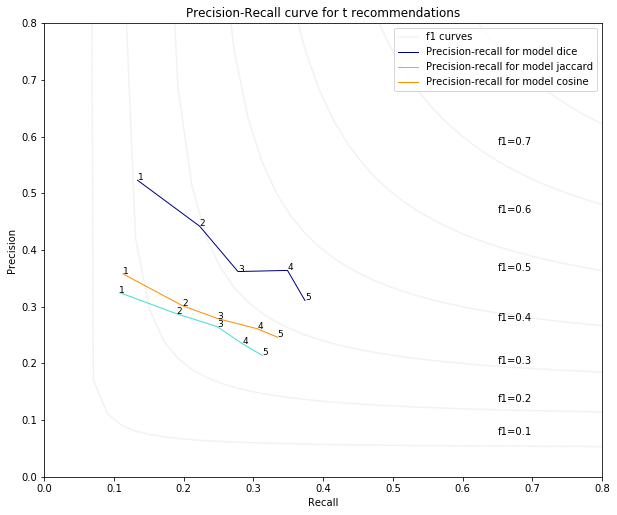

In [186]:
plot_precision_recall(precision_curves2, recall_curves2, models2)

### Testing with data limited on the 30 most recent orders (per customer)

In [187]:
gb = data.sort_values(by=['Member','Created On'], ascending=False).groupby(['Order'])['Member','Order'].head(1)

In [188]:
gb_df = gb.groupby(['Member']).head(30)

In [189]:
keys = list(gb_df.columns.values)
i1 = data.set_index(keys).index
i2 = gb_df.set_index(keys).index
data_30 = data[i1.isin(i2)].sort_values(by=['Created On'], ascending=True)

In [190]:
# Repeating the strategy of cutting the orders with less than 3 items.

x = data_30.groupby(['Order','Description']).size().unstack(fill_value=0)
y = x[x.sum(axis=1) > 3].index.tolist()

In [191]:
pr_curve8, re_curve8, members_metrics8 = cross_validate_forget(data_30[data_30['Order'].isin(y)], model_dice, 'Description')

Cross-validating the model ( model_dice ) with: 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.171 ) and F1-score std dev ( 0.074 ).
Model with 2 recommendations: F1-score mean ( 0.218 ) and F1-score std dev ( 0.052 ).
Model with 3 recommendations: F1-score mean ( 0.23 ) and F1-score std dev ( 0.067 ).
Model with 4 recommendations: F1-score mean ( 0.257 ) and F1-score std dev ( 0.059 ).
Model with 5 recommendations: F1-score mean ( 0.244 ) and F1-score std dev ( 0.047 ).


In [192]:
pr_curve9, re_curve9, members_metrics9 = cross_validate_forget(data_30, model_jaccard, 'Description')

Cross-validating the model ( model_jaccard ) with: 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.088 ) and F1-score std dev ( 0.042 ).
Model with 2 recommendations: F1-score mean ( 0.104 ) and F1-score std dev ( 0.037 ).
Model with 3 recommendations: F1-score mean ( 0.112 ) and F1-score std dev ( 0.045 ).
Model with 4 recommendations: F1-score mean ( 0.157 ) and F1-score std dev ( 0.043 ).
Model with 5 recommendations: F1-score mean ( 0.158 ) and F1-score std dev ( 0.04 ).


In [193]:
pr_curve10, re_curve10, members_metrics10 = cross_validate_forget(data_30, model_cosine, 'Description')

Cross-validating the model ( model_cosine ) with: 5 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.121 ) and F1-score std dev ( 0.062 ).
Model with 2 recommendations: F1-score mean ( 0.18 ) and F1-score std dev ( 0.059 ).
Model with 3 recommendations: F1-score mean ( 0.233 ) and F1-score std dev ( 0.057 ).
Model with 4 recommendations: F1-score mean ( 0.255 ) and F1-score std dev ( 0.071 ).
Model with 5 recommendations: F1-score mean ( 0.246 ) and F1-score std dev ( 0.063 ).


In [194]:
precision_curves3 = [pr_curve8, pr_curve9, pr_curve10]
recall_curves3 = [re_curve8, re_curve9, re_curve10]

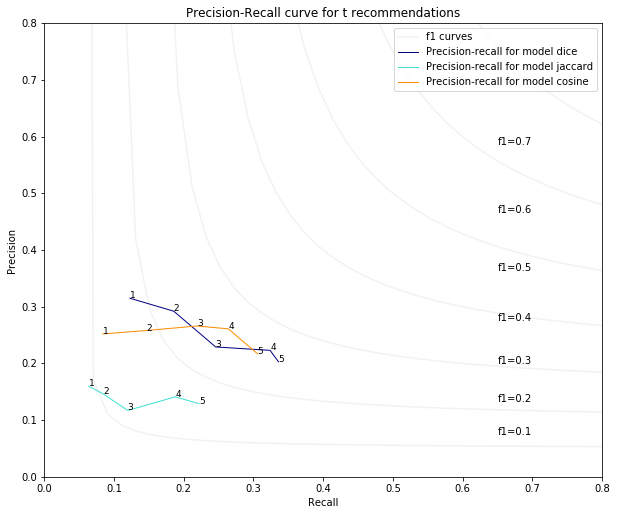

In [195]:
plot_precision_recall(precision_curves3, recall_curves3, models2)

### Validating results with spot-check 

- Simulating recommender for a single client

In [196]:
# Member: M99030
# an example of sub-group low

m99030_pr, m99030_re, m99030_metrics = cross_validate_forget(data, model_dice, 'Description', m_members = 1, member_id = 'M99030')

Cross-validating the model ( model_dice ) with: 1 member(s) and 5 different train/test splits.
Model with 1 recommendations: F1-score mean ( 0.411 ) and F1-score std dev ( 0.066 ).
Model with 2 recommendations: F1-score mean ( 0.499 ) and F1-score std dev ( 0.05 ).
Model with 3 recommendations: F1-score mean ( 0.535 ) and F1-score std dev ( 0.03 ).
Model with 4 recommendations: F1-score mean ( 0.52 ) and F1-score std dev ( 0.051 ).
Model with 5 recommendations: F1-score mean ( 0.493 ) and F1-score std dev ( 0.037 ).


In [197]:
print('Member --- #Recommendations --- Precision --- Recall --- F1-score --- F1 Std Dev')
for (key1, key2), value in m99030_metrics.items():
    print(key1,'         ',
          key2,'             ',
          value[0],'       ',
          value[1],'     ',
          value[2],'     ',
          value[3])

Member --- #Recommendations --- Precision --- Recall --- F1-score --- F1 Std Dev
M99030           1               0.717         0.29       0.411       0.066
M99030           2               0.607         0.426       0.499       0.05
M99030           3               0.526         0.548       0.535       0.03
M99030           4               0.458         0.605       0.52       0.051
M99030           5               0.387         0.679       0.493       0.037
